# Cloud points view of a mesh


### Twitter Driven Developement 

So Christophe Leterier[@christlet](https://twitter.com/christlet) and Felix Voilzel [@Flexi23](https://twitter.com/Flexi23) made this:

<blockquote class="twitter-tweet" data-partner="tweetdeck"><p lang="en" dir="ltr">I gave data to <a href="https://twitter.com/Flexi23">@Flexi23</a> and he developed... a SMLM 3D viewer in your web browser! This is excellencredible <a href="https://t.co/pTqUGlXVV6">pic.twitter.com/pTqUGlXVV6</a></p>&mdash; Christophe Leterrier (@christlet) <a href="https://twitter.com/christlet/status/791642533059293184">October 27, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>


![Actin filaments point cloud with Felix tool](https://pbs.twimg.com/media/Cvx6YT4WgAArHeH.jpg)

Now I have to try to generate a point cloud along the edges to simulate STORM images.


### Why?

Having a point based representation is not as futile as it sounds.

1. The file format is very simple (three columns), so easy to pass on
2. The point positions and densities can encode a lot of information
3. For our biology models, it is a straightforward route to reproducing 
   the images obtained from fluorescence microscopy, by simulating the
   (putative) distribution of a fluorescent markers
4. Thinking in terms of density fields is exciting



### Loading a tyssue dataset 

In [4]:
import pandas as pd
import numpy as np

from tyssue.io import hdf5
from tyssue import config
from tyssue.core.monolayer import Monolayer

import matplotlib.pyplot as plt
%matplotlib inline
try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found - install it for neater graphs')

from tyssue.io.csv import write_storm_csv
from tyssue.particles.point_cloud import EdgeSubdiv 

In [16]:
datasets = hdf5.load_datasets('../data/hf5/small_ellipsoid.hf5',
                              data_names=['vert', 'edge',
                                          'face', 'cell'])
specs = config.geometry.bulk_spec()

monolayer = Monolayer('ell', datasets, specs)
monolayer.reset_index()
monolayer.reset_topo()


## Generating particles from the edges


The idea is to simulate a STORM experiment, assuming our fluorophore is distributed along the edges.

Given the edge from the vertex at $\mathbf{r}_i$ to the one at $\mathbf{r}_j$, the possible positions of the particles are given by:

$$\mathbf{u}(s_{ij}) = \mathbf{r}_i + \mathbf{r}_{ij} s_{ij}, \quad s \in [0, 1]$$

Let $\delta_s$ be the spacing between two fluorphores, then we have $n_{ij} = \ell_{ij}/\delta_s$ fluorophores per edge.  
 

In [5]:
# Average number of particle by half-edge
density = 60
monolayer.edge_df['density'] = density / monolayer.edge_df.length.mean()
# Increase points density in the apical and basal layers
monolayer.edge_df.loc[monolayer.apical_edges, 'density'] *= 10.
monolayer.edge_df.loc[monolayer.basal_edges, 'density'] *= 10.

subdiv = EdgeSubdiv(monolayer.edge_df[['length', 'density']])
subdiv.specs['noise'] = 0.01
srce_pos = monolayer.upcast_srce(monolayer.vert_df[monolayer.coords])
r_ij = monolayer.edge_df[monolayer.dcoords]
subdiv.edge_point_cloud(srce_pos, r_ij)
subdiv.points.head()

,upcaster,offset,x,y,z
0,0,0.000000,0.497814,-0.031877,-1.004238
1,0,0.001748,0.501629,-0.020012,-0.975288
2,0,0.003497,0.513253,-0.038904,-0.986599
3,0,0.005245,0.512278,-0.025850,-0.980039
4,0,0.006993,0.499618,-0.036837,-0.996729


In [6]:
subdiv.edge_df.head()

,length,density,num_particles,x,dx,y,dy,z,dz
edge,,,,,,,,,
0,0.297880,1921.843043,572,0.513495,0.090703,-0.034393,0.281272,-0.985173,0.037306
1,0.294302,1921.843043,565,0.604199,0.138905,0.246878,0.043246,-0.947867,0.255829
2,0.314554,1921.843043,604,0.611858,-0.098363,-0.209700,0.175307,-0.743230,-0.241943
3,0.342045,1921.843043,657,0.777201,-0.165343,0.017019,-0.226719,-0.547642,-0.195588
4,0.310805,1921.843043,597,0.743104,0.034098,0.290125,-0.273106,-0.692038,0.144396


In [7]:
subdiv.n_edges, subdiv.n_points

(1656, 313912)

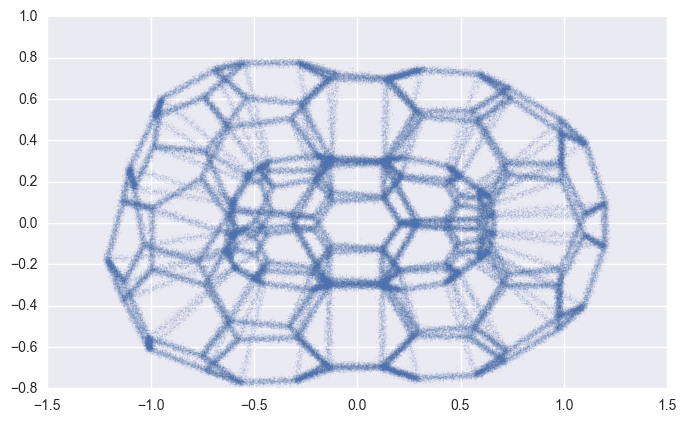

In [8]:
fig, ax = plt.subplots()
ax.plot(*subdiv.points[['z', 'x']].T.values, '.', ms=2., alpha=0.1)
ax.set_aspect('equal')


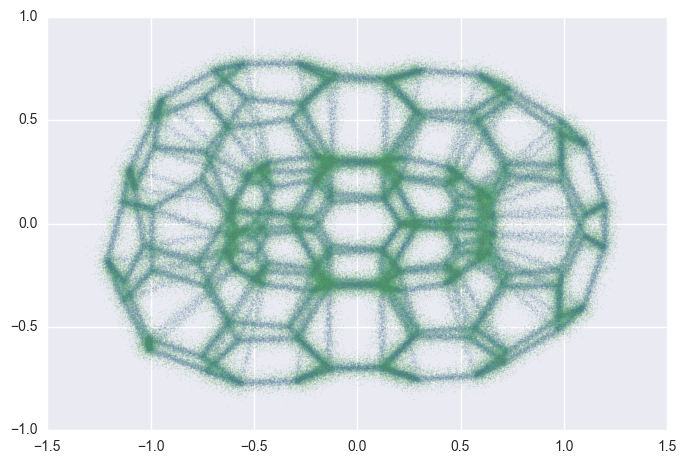

In [9]:
subdiv.specs['noise'] = 0.03
subdiv.edge_point_cloud(srce_pos, r_ij)
#fig, ax = plt.subplots()
ax.plot(*subdiv.points[['z', 'x']].T.values, '.', ms=2., alpha=0.1)
ax.set_aspect('equal')
fig

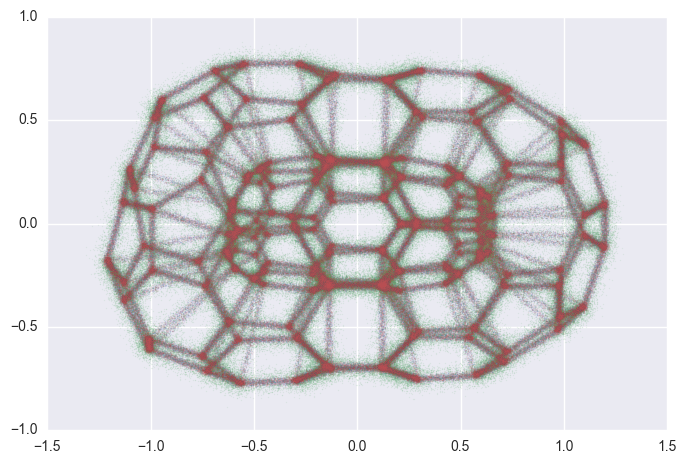

In [10]:
subdiv.specs['gamma'] = 1.8
subdiv.specs['noise'] = 0.01

subdiv.update_density_lut()
subdiv.update_offset()
subdiv.edge_point_cloud(srce_pos, r_ij)
#fig, ax = plt.subplots()
ax.plot(*subdiv.points[['z', 'x']].T.values, '.', ms=2., alpha=0.08)
ax.set_aspect('equal')
fig

In [11]:
## This is much slower, switch draw_scatter to execute
draw_scatter = False
if draw_scatter:
    fig, ax = plt.subplots()
    ax.scatter(subdiv.points.z.values,
               subdiv.points.x.values,
               marker='.', 
               s=subdiv.points.y.values*10,
               cmap='viridis',
               alpha=0.01)

    ax.set_aspect('equal')


### The 3D Storm format

Here is a screen shot of the file provided by Christophe:



![Crop of the 3D_STORM format in a tabulator](../data/png/3D_STORM_format.png)

In [12]:
### Configuration of the csv file format
csv_args = {'index':False, 'header':True, 'sep':'\t'}

subdiv.points['segment'] = monolayer.edge_df.loc[subdiv.points['upcaster'],
                                                 'segment'].values

filename = '../data/csv/ellipsoid'
write_storm_csv(filename, subdiv.points,
                coords=['x', 'y', 'z'],
                split_by=None, **csv_args)

In [13]:
ls -lht ../data/csv/

total 75M
-rw-r--r-- 1 guillaume guillaume  21M nov.   8 20:41 ellipsoid.csv
-rw-r--r-- 1 guillaume guillaume  16M nov.   8 20:16 ellipsoid_faces.csv
-rw-r--r-- 1 guillaume guillaume 238K nov.   6 19:43 ellipsoid_apical.csv
-rw-r--r-- 1 guillaume guillaume 2,8M nov.   6 19:26 ellipsoid_sagittal.csv
-rw-r--r-- 1 guillaume guillaume 2,8M nov.   6 19:26 ellipsoid_basal.csv
-rw-r--r-- 1 guillaume guillaume 4,0M oct.  28 10:43 ellipsoid_points_3.csv
-rw-r--r-- 1 guillaume guillaume 4,0M oct.  28 10:43 ellipsoid_points_2.csv
-rw-r--r-- 1 guillaume guillaume 8,6M oct.  28 10:43 ellipsoid_points_1.csv
-rw-r--r-- 1 guillaume guillaume  17M oct.  28 10:43 ellipsoid_points.csv


Now you can upload `ellipsoid_points.csv`, to [Felix's website](http://cake23.de/pointcloud-loader/) and voilà!
![Awesome](../data/png/tyssue_storm.png)


Here is the implementation of `write_storm_csv`.

```python
csv_args = {'index':False, 'header':True, 'sep':'\t'}
```

```python
def write_storm_csv(filename, points,
                    coords=['x', 'y', 'z'],
                    split_by=None, **csv_args):

    columns = ['frame', 'x [nm]', 'y [nm]', 'z [nm]',
               'uncertainty_xy', 'uncertainty_z']
    points = points.dropna()
    storm_points = pd.DataFrame(np.zeros((points.shape[0], 6)),
                                columns=columns)
    storm_points[['x [nm]', 'y [nm]', 'z [nm]']] = points[coords]
    storm_points['frame'] = 1
    storm_points[['uncertainty_xy',
                  'uncertainty_z']] = 2.1
    # tab separated values are faster and more portable than excel
    if split_by is None:
        if not filename.endswith('.csv'):
            filename = filename+'.csv'
        storm_points.to_csv(filename, **csv_args)
    elif split_by in points.columns():
        storm_points[split_by] = points[split_by]
        # separated files by the column split_by
        storm_points.groupby(split_by).apply(
            lambda df:df.to_csv('{}_{}.csv'.format(
                filename, df[split_by].iloc[0]),
                **csv_args))
```

## Generating particles from the faces

Let the average edge length $\ell$ be the unit length.


We basically are constructing a local base (non orthogonal, but direct)
with two edges:
* the edge from the face center at $\mathbf{r}_\alpha$ to the vertex at $\mathbf{r}_i$, $\mathbf{r}_{\alpha i}$ 

* the edge from the face center at $\mathbf{r}_\alpha$ to the vertex at $\mathbf{r}_j$, $\mathbf{r}_{\alpha j}$ 

The positions of the particles are expressed in this base.
In general, the postion of M is given by:
$$
\mathbf{r}_M = \mathbf{r}_\alpha
    + u_{\alpha i}^{M}  \mathbf{e}_{\alpha i}
    + u_{\alpha j}^{M} \mathbf{e}_{\alpha j}
$$

On the regular grid, the particle $M^{nm}$ has a position:

$$
\mathbf{r}_M^{nm} = \mathbf{r}_\alpha + n \,\mathbf{e}_{\alpha i} + m\,\mathbf{e}_{\alpha j},\quad n < N_i, m < M_j
$$

But regular grids are boring, so...

This gid can be deformed by introducing a scale free density modulation function $\sigma_{\alpha i}(k)$ such that:
$$
u_{\alpha i}^k = k \sigma_{\alpha i}(k), \quad \sigma_{\alpha i}(k)\in [0, 1]
$$
 

![Diagramm of face subdivision grid](../data/png/face_subdivision.png)

```python
# Not working for non square matrix:
n, m = 12, 18
ii, jj = np.tril_indices(n, k=0)
density = 5

x = (np.arange(n, 0, -1)/density)[ii]
y = (np.arange(0, m)/density)[jj]

fig, ax = plt.subplots()
for i, j in zip(ii, jj):
    pass
#x = x.max() - x
ax.plot(x, y, 'o')
ax.plot(0, 0, '+')
ax.set_aspect('equal')
ax.set_xlim(-0.1, n/density+0.1)
ax.set_ylim(-0.1, m/density+0.1)
```


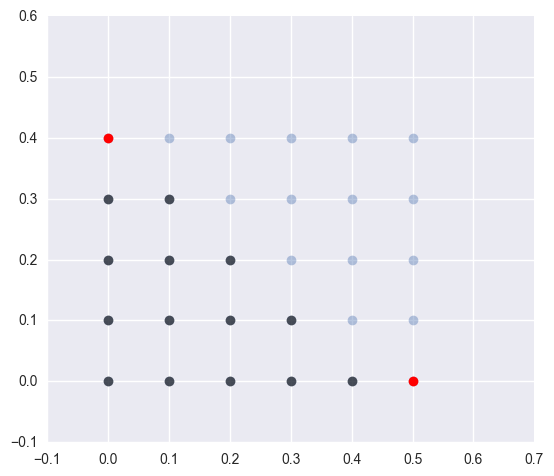

In [14]:
n, m = 6, 5
density = 10
x = np.arange(0, n)/density
y = np.arange(0, m)/density

xx, yy = np.meshgrid(x, y)

l_ai, l_aj = xx.max(), yy.max()
in_out = (l_ai * l_aj - (l_aj*xx +
                         l_ai*yy)) > 0

fig, ax = plt.subplots()

ax.plot(xx.ravel(), yy.ravel(), 'o', alpha=0.4)

ax.plot(xx[in_out].ravel(), 
        yy[in_out].ravel(), 'ko', alpha=0.6)
ax.plot(0, l_aj, 'ro')
ax.plot(l_ai, 0, 'ro')
ax.set_xlim(-0.1, n/density+0.1)
ax.set_ylim(-0.1, m/density+0.1)

ax.set_aspect('equal')



In [64]:
np.product([3, 5])

15

In [30]:
class FaceGrid:
    
    def __init__(self, edges_df, **kwargs):
        
        self.subdivs = {key: EdgeSubdiv(edge_df, **kwargs)
                        for key, edge_df in edges_df.items()}
        
        update_attrs = ['density_lut', 'particles',
                        'upcaster', 'offset']
        
        self.n_points = np.product([subdiv.n_points for subdiv
                                    in self.subdivs.values()])
        self.dim = len(self.subdivs)
        self.up_cols = ['up_{}'.format(key) for key in self.subdivs]
        self.of_cols = ['of_{}'.format(key) for key in self.subdivs]
        grid_columns = self.up_cols + self.of_cols
        self.points = pd.DataFrame(
            np.zeros((self.n_points, 
                      len(grid_columns))),
            columns=grid_columns)
        
    def update_grid(self):
        upcasters = pd.DataFrame.from_dict(
            {key: subdiv.points['upcaster'].values
             for key, subdiv in self.subdivs.values()})
        
        
    def update_grid_offset(self):
        off_grid = np.meshgrid(
            *(subdiv.points['offset'].values
            for subdiv in self.subdivs.values()))
        
        for i, col in enumerate(self.of_cols):
            self.points[col] = off_grid[i].ravel()

    
def local_grid(df):
    nn, mm = np.meshgrid(*(col for name, col
                           in df.iteritems()))
    return nn, mm
    

<generator object DataFrame.iteritems at 0x7f7fa0304990>

In [6]:
%pdb

Automatic pdb calling has been turned ON


In [31]:
from tyssue.core import generation
from tyssue.core.sheet import Sheet
from tyssue.geometry.sheet_geometry import PlanarGeometry as geom
from tyssue.draw.plt_draw import quick_edge_draw

specs = config.geometry.planar_sheet()
datasets, _ = generation.three_faces_sheet()

eptm = Sheet('3_sheet', datasets, specs)
geom.update_all(eptm)


def upcast_cols(eptm, element, cols):
    if element in ['srce', 'trgt']:
        dataset = 'vert'
    else:
        dataset = element
    return eptm._upcast(eptm.edge_df[element], 
                        eptm.datasets[dataset][cols])


def get_edge_bases(eptm, center='face',
                   source='srce', target='trgt'):

    edge_upcast_pos = {element: upcast_cols(eptm, element, eptm.coords)
                       for element in [center, source, target]}
    edge_bases = {}
    for vertex in (source, target):
        df = pd.DataFrame(0, columns=eptm.coords+eptm.dcoords+['length',],
                          index=eptm.edge_df.index)
        df[eptm.dcoords] = (edge_upcast_pos[vertex].values -
                            edge_upcast_pos[center].values)
        
        df['length'] = np.linalg.norm(df[eptm.dcoords].values, axis=1)

        df[eptm.coords] = edge_upcast_pos[center].values
        edge_bases['{}_{}'.format(center, vertex)] = df.copy()
    return edge_bases
        
base_edges = get_edge_bases(eptm, 'face', 'srce', 'trgt')
f_grid = FaceGrid(base_edges)
#f_grid.update_grid_upcaster()
#f_grid.update_grid_offset()

In [45]:
def local_grid(df, col1, col2):
    nn, mm = np.meshgrid(df.col1.values,
                         df.col2.values)
    
    gr = pd.DataFrame.from_dict({'nn': nn.ravel(),
                                 'mm': mm.ravel()})
    return gr

upcasters = pd.DataFrame.from_dict(
    {key: subdiv.points['upcaster'].values
     for key, subdiv in f_grid.subdivs.items()})
  

In [51]:
gr = eptm.edge_df.groupby('srce')
gr.apply()

In [47]:
upcaster = upcasters.groupby('face_srce').apply(local_grid)

In [48]:
upcaster.shape

(576, 2)

In [52]:
(f_grid.subdivs['face_srce'].edge_df['num_particles'] *
 f_grid.subdivs['face_trgt'].edge_df['num_particles']).sum()*2

576

In [21]:
nn, mm = np.meshgrid(np.arange(72), np.arange(72))

In [23]:
nn.size

5184

In [28]:
n_u, n_v = (subdiv.n_points for subdiv in f_grid.subdivs.values())
total_grid_size = n_u * n_v
print('Face to source upcaster: {} subdivisions'.format(n_u))
print('Face to target upcaster: {} subdivisions'.format(n_v))
print('Total grid size: {}'.format(total_grid_size))

Face to source upcaster: 72 subdivisions
Face to target upcaster: 72 subdivisions
Total grid size: 5184


In [9]:
def face_point_cloud(f_grid,  coords=['x', 'y', 'z'],
                     dcoords=['dx', 'dy', 'dz']):
    upcast = {}
    for key, subdiv in f_grid.subdivs.items():
        upcast[key] = subdiv.edge_df.loc[f_grid.points['up_{}'.format(key)],
                                         eptm.coords+eptm.dcoords+['length']].copy()
        upcast[key].reset_index(inplace=True)
        upcast[key]['offset'] = f_grid.points['of_{}'.format(key)].values

    for u, du in zip(coords, dcoords):
        f_grid.points[u] = (upcast['face_srce'].eval('{} + offset * {}'.format(u, du)).values +
                            upcast['face_trgt'].eval('offset * {}'.format(du)).values)
    
    l_ai = upcast['face_srce']['length']
    l_aj = upcast['face_trgt']['length']
    xx = f_grid.points['of_face_srce']
    yy = f_grid.points['of_face_trgt']

    in_out = (l_ai * l_aj - (l_aj*xx + l_ai*yy))
    f_grid.points = f_grid.points[in_out > 0]

In [10]:
face_point_cloud(f_grid, eptm.coords, eptm.dcoords)
f_grid.points.head()

,up_face_trgt,up_face_srce,of_face_trgt,of_face_srce,x,y,z
0,0,0,0.00,0.0,0.500,0.8660,0.0
1,0,0,0.25,0.0,0.625,0.6495,0.0
2,0,0,0.50,0.0,0.750,0.4330,0.0
3,0,0,0.75,0.0,0.875,0.2165,0.0
4,1,0,0.00,0.0,0.500,0.8660,0.0


In [11]:
f_grid.subdivs['face_srce'].specs

{'density': 4, 'gamma': 1.0, 'noise': 0, 'scale': 1, 'start': 0.0, 'stop': 1.0}

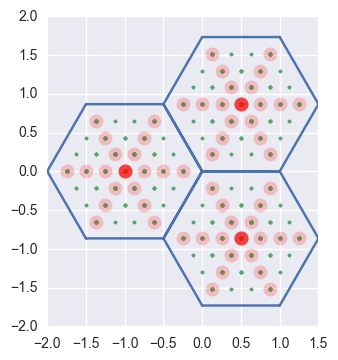

In [13]:
fig, ax = quick_edge_draw(eptm)
ax.plot(*f_grid.points[['x', 'y']].T.values,
        '.', ms=5., alpha=0.5)
ax.set_aspect('equal')

r_ij = f_grid.subdivs['face_srce'].edge_df[eptm.dcoords]
srce_pos = eptm.upcast_face(eptm.face_df[eptm.coords])
f_grid.subdivs['face_srce'].edge_point_cloud(srce_pos, r_ij)
points = f_grid.subdivs['face_srce'].points
ax.plot(*points[['x', 'y']].T.values,
        'ro', ms=10., alpha=0.2)


In [14]:
fig.savefig('3_cells.svg')

In [17]:
eptm = monolayer.get_sub_sheet('apical')

base_edges = get_edge_bases(eptm, 'face', 'srce', 'trgt')
f_grid = FaceGrid(base_edges, density=10)
f_grid.update_grid_upcaster()
f_grid.update_grid_offset()
face_point_cloud(f_grid, eptm.coords, eptm.dcoords)


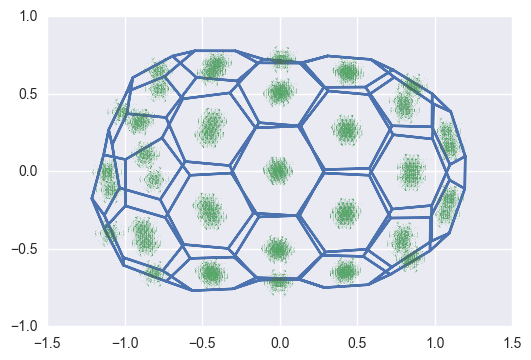

In [18]:
fig, ax = quick_edge_draw(eptm, ['z', 'x'])
ax.plot(*f_grid.points[['z', 'x']].T.values,
        '.', ms=1., alpha=0.04)
ax.set_aspect('equal')

In [19]:
r_ij = f_grid.subdivs['face_srce'].edge_df[eptm.dcoords]
srce_pos = eptm.upcast_face(eptm.face_df[eptm.coords])
f_grid.subdivs['face_srce'].edge_point_cloud(srce_pos, r_ij)

r_ij = f_grid.subdivs['face_trgt'].edge_df[eptm.dcoords]
srce_pos = eptm.upcast_face(eptm.face_df[eptm.coords])
f_grid.subdivs['face_trgt'].edge_point_cloud(srce_pos, r_ij)


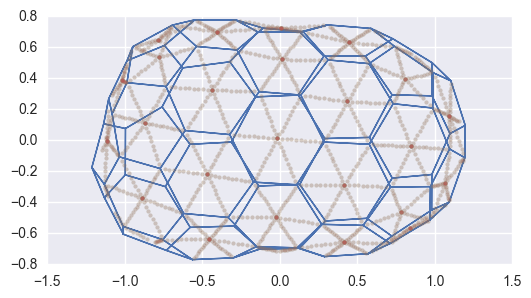

In [20]:
fig, ax = quick_edge_draw(eptm, ['z', 'x'], lw=1)
for key in f_grid.subdivs:
    points = f_grid.subdivs[key].points[['x', 'y', 'z']]
    ax.plot(*points[points['y'] > 0][['z', 'x']].T.values,
            'o', ms=3., alpha=0.2)
    ax.set_aspect('equal')

In [76]:
filename = '../data/csv/ellipsoid_faces'
write_storm_csv(filename, f_grid.points,
                split_by=None,#'segment',
                **csv_args)

In [77]:
!ls -lht ../data/csv/

total 101M
-rw-r--r-- 1 guillaume guillaume  42M nov.   8 21:42 ellipsoid_faces.csv
-rw-r--r-- 1 guillaume guillaume  21M nov.   8 20:41 ellipsoid.csv
-rw-r--r-- 1 guillaume guillaume 238K nov.   6 19:43 ellipsoid_apical.csv
-rw-r--r-- 1 guillaume guillaume 2,8M nov.   6 19:26 ellipsoid_sagittal.csv
-rw-r--r-- 1 guillaume guillaume 2,8M nov.   6 19:26 ellipsoid_basal.csv
-rw-r--r-- 1 guillaume guillaume 4,0M oct.  28 10:43 ellipsoid_points_3.csv
-rw-r--r-- 1 guillaume guillaume 4,0M oct.  28 10:43 ellipsoid_points_2.csv
-rw-r--r-- 1 guillaume guillaume 8,6M oct.  28 10:43 ellipsoid_points_1.csv
-rw-r--r-- 1 guillaume guillaume  17M oct.  28 10:43 ellipsoid_points.csv


In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2)

ax0.plot(mesh.length.values/delta_s, 'o', alpha=0.2)
ax0.plot(upcast_nij, 'o', alpha=0.1)
ax0.set_ylabel('Number of points')

e_start, e_stop = 1000, 1010

p_start, p_stop = (curv_indexer[curv_indexer < e_start].size,
                   curv_indexer[curv_indexer < e_stop].size )

ax1.plot(ramps[p_start: p_stop], '-o', alpha=0.8)
ax1.set_ylim(-0.1, 1.1)
ax1.set_ylabel('normalized coordinate along the edges')

fig.set_size_inches((12, 6))
fig